In [1]:
!nvidia-smi

Sat Mar 29 08:15:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [4]:
!yolo task=detect mode=predict model=yolo11l-seg.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 53.5M/53.5M [00:00<00:00, 58.9MB/s]
WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l-seg summary (fused): 491 layers, 27,646,272 parameters, 0 gradients, 142.2 GFLOPs

100% 104k/104k [00:00<00:00, 101MB/s]
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 backpack, 74.3ms
Speed: 15.0ms preprocess, 74.3ms inference, 433.8ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

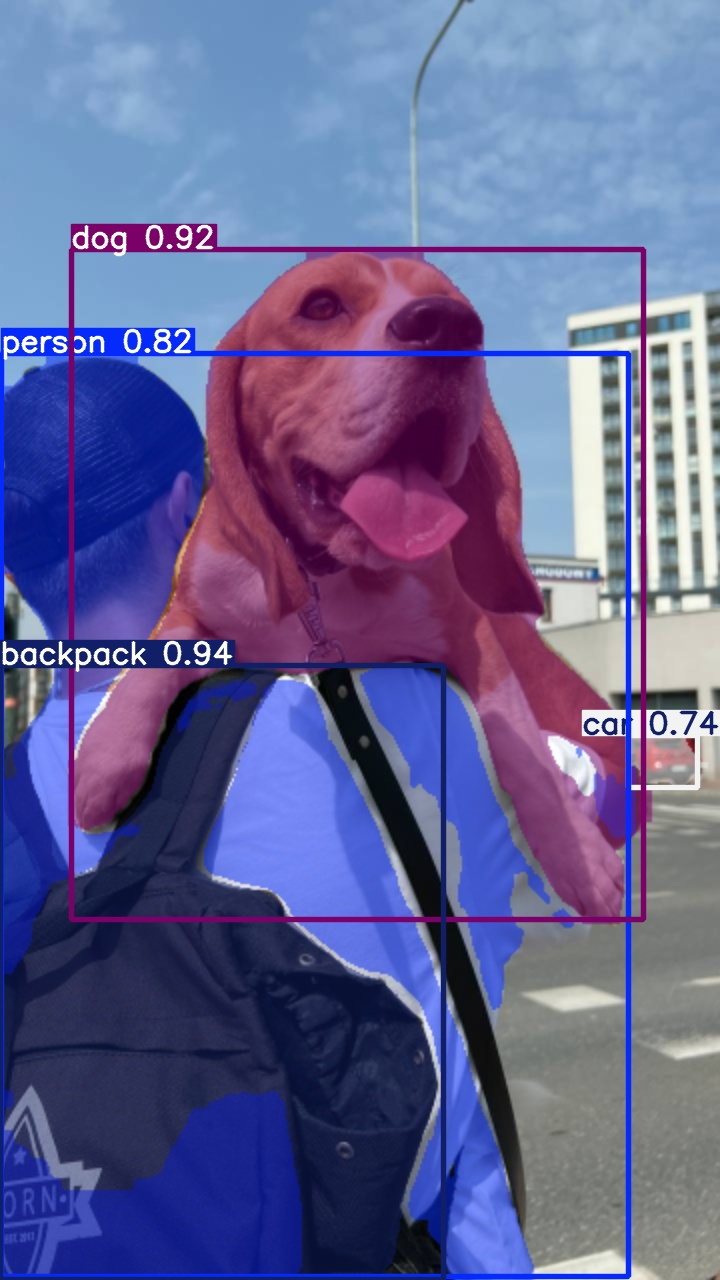

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/segment/predict/dog.jpg', width=600)

In [ ]:
!yolo task=segment mode=predict model=yolo11s-seg.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 19.7M/19.7M [00:00<00:00, 26.9MB/s]
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11s-seg summary (fused): 265 layers, 10,097,776 parameters, 0 gradients, 35.5 GFLOPs

Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 2 dogs, 1 backpack, 1 handbag, 921.8ms
Speed: 3.1ms preprocess, 921.8ms inference, 55.1ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/segment/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/woman.jpg', width=600)

FileNotFoundError: [Errno 2] No such file or directory: '/content/woman.jpg'

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11l-seg.pt')
image_path = r'/content/download.jpg'
image = Image.open(image_path)

# Perform inference
results = model.predict(image, conf=0.25)

**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

In [ ]:
result.boxes.conf

In [ ]:
result.boxes.cls

In [ ]:
result.masks.data

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [ ]:
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_position=sv.Position.CENTER)

annotated_image = image.copy()
annotated_image = mask_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/ks-fsm9o/pelvis-ap-x-ray) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
from google.colab import files

# Upload the file.
uploaded = files.upload()


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VgUE8WMKXqEH3RtQIUl8")
project = rf.workspace("deep-learning-uhyyo").project("underwater-instance-segmentation")
version = project.version(3)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Underwater-Instance-Segmentation-3 in yolov11:: 100%|██████████| 5519/5519 [00:02<00:00, 2661.92it/s]


In [6]:
# import os

# # Define label paths
# label_dirs = [
#     "/content/Foodifyyy/train/labels",
#     "/content/Foodifyyy/valid/labels",
#     "/content/Foodifyyy/test/labels"
# ]

# # Remove empty label files
# for label_dir in label_dirs:
#     if os.path.exists(label_dir):
#         for label_file in os.listdir(label_dir):
#             label_path = os.path.join(label_dir, label_file)
#             if os.path.isfile(label_path) and os.path.getsize(label_path) == 0:
#                 print(f"Removing empty label: {label_path}")
#                 os.remove(label_path)


## Custom Training

In [7]:
# import os
# from ultralytics import YOLO

# # Define paths
# best_model_path = '/content/Underwater-Instance-Segmentation-3/best.pt'  # Desired path for the best model
# initial_model_path = '/content/Underwater-Instance-Segmentation-3/yolo11s-seg.pt'  # Path to the initial model
# data_yaml_path = '/content/Underwater-Instance-Segmentation-3/data.yaml'  # Path to the data.yaml file in the dataset

# # Check if the best model already exists
# if os.path.exists(best_model_path):
#     print(f"Best model already exists at {best_model_path}. Skipping training.")
# else:
#     # Load the YOLOv8 segmentation model
#     model = YOLO(initial_model_path)

#     # Start training
#     results = model.train(
#         data=data_yaml_path,
#         epochs=50,  # Increased epochs for better learning
#         imgsz=640,
#         batch=16,
#         name='train',
#         task='segment',
#         project='/content/Underwater-Instance-Segmentation-3/runs/segment',
#         exist_ok=True,
#         device=0,  # Use GPU if available
#         verbose=True,
#         conf=0.1,  # Lower confidence threshold for better recall
#         iou=0.7,  # Higher IoU for better NMS
#         mosaic=1  # Enable multi-scale training
#     )

#     # Move the best model to the desired location
#     trained_best_model_path = os.path.join(results.save_dir, 'weights', 'best.pt')
#     os.rename(trained_best_model_path, best_model_path)
#     print(f"Training completed. Best model saved at {best_model_path}.")


**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [8]:
import os
from ultralytics import YOLO

# Define paths
best_model_path = '/content/Underwater-Instance-Segmentation-3/best.pt'  # Path to save the best model
initial_model_path = '/content/Underwater-Instance-Segmentation-3/yolo11s-seg.pt'  # Initial model path
data_yaml_path = '/content/Underwater-Instance-Segmentation-3/data.yaml'  # Path to the data.yaml file

# Check if the best model already exists
if os.path.exists(best_model_path):
    print(f"✅ Best model already exists at {best_model_path}. Skipping training.")
else:
    # Load the YOLO segmentation model
    model = YOLO(initial_model_path)

    # Start training with optimized settings
    results = model.train(
        data=data_yaml_path,
        epochs=50,                # Increased epochs for better learning
        imgsz=640,                # Input image size
        batch=32,                 # Increased batch size for smoother gradient updates
        name='train',
        task='segment',
        project='/content/Underwater-Instance-Segmentation-3/runs/segment',
        exist_ok=True,
        device=0,                 # Use GPU if available
        verbose=True,

        # Optimized settings for better precision and recall
        lr0=0.01,                 # Initial learning rate
        lrf=0.0001,               # Final learning rate after decay
        warmup_epochs=3,          # Warm-up period to avoid overshooting
        cos_lr=True,              # Use cosine learning rate decay

        # Advanced augmentations to improve generalization
        hsv_h=0.015,              # Hue variation
        hsv_s=0.7,                # Saturation variation
        hsv_v=0.4,                # Brightness variation
        flipud=0.5,               # Vertical flip
        fliplr=0.5,               # Horizontal flip
        mosaic=1.0,               # Mosaic augmentation
        mixup=0.2,                # Mixup augmentation

        # Confidence and IoU thresholds
        conf=0.4,                 # Higher confidence threshold for fewer false positives
        iou=0.6                   # IoU threshold to improve NMS
    )

    # Move the best model to the desired location
    trained_best_model_path = os.path.join(results.save_dir, 'weights', 'best.pt')
    os.rename(trained_best_model_path, best_model_path)
    print(f"🎉 Training completed. Best model saved at {best_model_path}.")


100%|██████████| 19.7M/19.7M [00:00<00:00, 24.9MB/s]


New https://pypi.org/project/ultralytics/8.3.98 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=/content/Underwater-Instance-Segmentation-3/yolo11s-seg.pt, data=/content/Underwater-Instance-Segmentation-3/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/Underwater-Instance-Segmentation-3/runs/segment, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.4, iou=0.6, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, 

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 99.7MB/s]


AMP: checks passed ✅


train: Scanning /content/Underwater-Instance-Segmentation-3/train/labels... 2748 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2748/2748 [00:02<00:00, 1109.92it/s]


train: New cache created: /content/Underwater-Instance-Segmentation-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Underwater-Instance-Segmentation-3/valid/labels... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<00:00, 439.50it/s]

val: New cache created: /content/Underwater-Instance-Segmentation-3/valid/labels.cache


Plotting labels to /content/Underwater-Instance-Segmentation-3/runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/Underwater-Instance-Segmentation-3/runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.9G      1.602      3.598       2.59      1.702        270        640: 100%|██████████| 86/86 [01:46<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7         47      0.116      0.185      0.156       0.12      0.118      0.192      0.164      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.5G      1.603      3.467      2.205      1.691        386        640: 100%|██████████| 86/86 [01:36<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all          7         47        0.2      0.104      0.156      0.125        0.2      0.104      0.156       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.3G      1.599       3.44      2.177      1.671        366        640: 100%|██████████| 86/86 [01:36<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all          7         47      0.134      0.106      0.107     0.0724      0.144      0.113      0.113     0.0749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.3G      1.608       3.46       2.16      1.685        380        640: 100%|██████████| 86/86 [01:37<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all          7         47      0.227      0.187       0.21      0.123      0.216      0.184      0.199      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.3G      1.539      3.379      2.112      1.639        297        640: 100%|██████████| 86/86 [01:36<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all          7         47      0.229      0.136      0.182      0.129      0.229      0.136      0.182      0.124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50        12G      1.528      3.326      2.082      1.633        330        640: 100%|██████████| 86/86 [01:37<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all          7         47       0.22     0.0863      0.133      0.105      0.216     0.0916      0.139     0.0984



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50        12G      1.483      3.232      2.005      1.605        300        640: 100%|██████████| 86/86 [01:34<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all          7         47       0.35      0.359      0.357      0.204       0.37      0.375      0.378      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.2G      1.472      3.221      1.971      1.599        319        640: 100%|██████████| 86/86 [01:35<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all          7         47      0.274      0.191      0.223      0.164      0.284      0.198      0.229      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.7G      1.445       3.17      1.967       1.59        437        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all          7         47      0.321      0.126      0.223      0.127      0.311      0.146      0.233      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      12.9G      1.438       3.14      1.912      1.566        308        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all          7         47      0.278      0.149      0.211      0.162      0.278      0.149      0.211      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      12.3G       1.43      3.141      1.933      1.567        401        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all          7         47      0.233      0.136      0.189      0.139      0.241      0.143      0.194       0.13



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.5G      1.409       3.09        1.9      1.553        420        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all          7         47      0.246      0.156      0.197      0.148      0.253      0.163      0.202      0.141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50        13G      1.408      3.088      1.878      1.553        381        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all          7         47      0.223      0.208      0.216      0.158      0.229      0.215      0.222      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      12.6G      1.386      3.045      1.836       1.53        350        640: 100%|██████████| 86/86 [01:34<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all          7         47      0.542        0.3      0.334      0.161      0.616      0.316      0.378      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      12.7G      1.369      2.986      1.817      1.516        407        640: 100%|██████████| 86/86 [01:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all          7         47      0.269      0.185      0.236       0.16      0.269      0.185      0.236      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      12.4G      1.379      2.987      1.787      1.511        327        640: 100%|██████████| 86/86 [01:36<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all          7         47      0.236      0.178      0.197      0.167      0.258      0.195       0.22      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      13.1G      1.341      2.953      1.779      1.504        383        640: 100%|██████████| 86/86 [01:36<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all          7         47      0.249      0.189      0.234       0.17      0.255      0.195      0.242      0.168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50        12G      1.332      2.924      1.753      1.485        345        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all          7         47        0.4      0.319      0.355       0.23      0.453      0.336      0.387      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.3G      1.318      2.905      1.748      1.483        446        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all          7         47      0.376      0.372      0.398      0.269      0.379      0.379       0.41      0.283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      12.6G      1.308      2.878      1.732       1.47        283        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all          7         47       0.24      0.163      0.211      0.156      0.246      0.169      0.217       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50        13G      1.323      2.907      1.729      1.485        352        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all          7         47      0.303      0.169      0.243      0.196      0.311      0.176      0.247      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      12.1G      1.299      2.851      1.704      1.471        393        640: 100%|██████████| 86/86 [01:36<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all          7         47       0.57      0.323      0.377      0.267      0.618      0.339      0.407      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      12.9G      1.279      2.844      1.678      1.453        397        640: 100%|██████████| 86/86 [01:35<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all          7         47      0.412      0.342      0.383      0.262      0.419      0.349       0.39      0.279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      12.2G      1.283      2.799      1.668      1.454        376        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          7         47      0.244      0.149      0.202      0.165      0.252      0.156      0.209      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.3G      1.273      2.796      1.655      1.446        398        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all          7         47      0.424      0.372        0.4      0.271      0.431      0.378      0.407      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.1G      1.262      2.766       1.64      1.438        287        640: 100%|██████████| 86/86 [01:37<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all          7         47      0.566        0.5      0.577       0.31      0.492      0.349      0.418      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.4G       1.24      2.776      1.643      1.438        347        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all          7         47      0.433      0.378      0.413      0.264       0.44      0.385      0.419      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50        12G      1.249      2.751      1.607      1.423        591        640: 100%|██████████| 86/86 [01:38<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all          7         47      0.387      0.365      0.398      0.272      0.384      0.367      0.403      0.279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      11.1G      1.253      2.753      1.609      1.428        445        640: 100%|██████████| 86/86 [01:38<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all          7         47      0.428      0.339      0.387      0.242      0.428      0.339      0.387      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.8G      1.235      2.743      1.586      1.421        250        640: 100%|██████████| 86/86 [01:40<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all          7         47      0.639      0.535      0.588      0.277      0.639      0.535      0.588      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.1G      1.225      2.683      1.567      1.418        330        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all          7         47      0.412      0.342      0.392      0.275      0.419      0.349      0.397      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.6G      1.222      2.709      1.572      1.416        383        640: 100%|██████████| 86/86 [01:38<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all          7         47      0.443      0.365      0.409      0.279      0.451      0.372      0.417      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.6G      1.205      2.641      1.537      1.395        286        640: 100%|██████████| 86/86 [01:36<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all          7         47      0.583      0.545      0.564       0.31      0.583      0.545      0.565      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.9G      1.197      2.617      1.528      1.388        393        640: 100%|██████████| 86/86 [01:37<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7         47      0.399      0.378        0.4      0.258      0.405      0.385      0.404      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.9G      1.191      2.646      1.516      1.397        331        640: 100%|██████████| 86/86 [01:37<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all          7         47      0.602      0.535      0.573      0.302      0.449      0.369      0.415      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.7G      1.186      2.611      1.505      1.386        356        640: 100%|██████████| 86/86 [01:37<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all          7         47      0.632      0.538      0.581      0.313      0.472      0.378      0.424      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      12.5G      1.174        2.6      1.501      1.383        360        640: 100%|██████████| 86/86 [01:35<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all          7         47       0.63      0.538      0.577      0.302      0.637      0.545      0.586      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.8G      1.176      2.582      1.484      1.376        347        640: 100%|██████████| 86/86 [01:36<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          7         47      0.619      0.545      0.584      0.326      0.625      0.552      0.592      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.3G      1.195      2.655      1.499      1.389        378        640: 100%|██████████| 86/86 [01:37<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all          7         47      0.604      0.538       0.58      0.346      0.612      0.545      0.588       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      12.1G      1.167      2.565      1.472      1.373        335        640: 100%|██████████| 86/86 [01:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all          7         47      0.449      0.365      0.406      0.287      0.457      0.372      0.415      0.306


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.9G      1.054      1.984      1.232      1.254        149        640: 100%|██████████| 86/86 [01:19<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all          7         47      0.772      0.464      0.545      0.392       0.78       0.47      0.551      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.2G      1.039      1.925      1.162      1.246        179        640: 100%|██████████| 86/86 [01:16<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


                   all          7         47      0.788      0.632      0.712      0.405      0.795      0.638      0.721      0.397

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.1G       1.03      1.912      1.157      1.235        202        640: 100%|██████████| 86/86 [01:16<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all          7         47      0.752      0.645      0.707      0.439      0.759      0.652      0.716      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.2G      1.012      1.893      1.136      1.227        165        640: 100%|██████████| 86/86 [01:16<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all          7         47      0.777      0.622      0.702      0.406      0.784      0.628      0.712      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      11.3G      1.021      1.894      1.116      1.235        172        640: 100%|██████████| 86/86 [01:16<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


                   all          7         47      0.761      0.627      0.704      0.404      0.768      0.634      0.712      0.429

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.3G      1.007      1.873      1.105      1.221        175        640: 100%|██████████| 86/86 [01:16<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

                   all          7         47      0.771      0.621      0.694      0.394      0.778      0.627      0.703      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.7G      1.013      1.857      1.109      1.233        123        640: 100%|██████████| 86/86 [01:17<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


                   all          7         47      0.735      0.638      0.697      0.396      0.778      0.623      0.707      0.408

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.3G      1.003      1.864      1.095      1.219        159        640: 100%|██████████| 86/86 [01:17<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


                   all          7         47      0.769      0.622      0.696      0.395      0.777      0.628      0.705      0.408

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.7G     0.9975      1.853      1.091      1.213        121        640: 100%|██████████| 86/86 [01:16<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all          7         47      0.778      0.621      0.696      0.394      0.786      0.628      0.704      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.2G          1      1.858      1.091      1.224        179        640: 100%|██████████| 86/86 [01:17<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all          7         47      0.777      0.622      0.691      0.395      0.788      0.628        0.7      0.405



50 epochs completed in 1.324 hours.
Optimizer stripped from /content/Underwater-Instance-Segmentation-3/runs/segment/train/weights/last.pt, 20.5MB
Optimizer stripped from /content/Underwater-Instance-Segmentation-3/runs/segment/train/weights/best.pt, 20.5MB

Validating /content/Underwater-Instance-Segmentation-3/runs/segment/train/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,069,525 parameters, 0 gradients, 35.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


                   all          7         47      0.746      0.645      0.707      0.438      0.757      0.652      0.716      0.441
        aquatic plants          1          1          1          1      0.995      0.398          1          1      0.995      0.697
                  fish          4         25      0.724       0.84      0.807      0.655       0.77       0.88       0.86      0.617
          human divers          1          1          1          1      0.995      0.298          1          1      0.995      0.199
                 reefs          4         17       0.75      0.529      0.696      0.599       0.77      0.529      0.696      0.532
                robots          2          2          1        0.5       0.75      0.675          1        0.5       0.75        0.6
             sea-floor          1          1          0          0          0          0          0          0          0          0
Speed: 0.3ms preprocess, 5.8ms inference, 0.0ms loss, 1.4ms postproce

In [9]:
import os
import glob

# Define the path to the training directory
train_dir = '/content/Underwater-Instance-Segmentation-3/runs/segment/train'

# Check if the directory exists
if os.path.exists(train_dir):
    # List all files in the directory
    files = glob.glob(os.path.join(train_dir, '*'))
    for file in files:
        print(file)
else:
    print(f"The directory {train_dir} does not exist.")


/content/Underwater-Instance-Segmentation-3/runs/segment/train/MaskF1_curve.png
/content/Underwater-Instance-Segmentation-3/runs/segment/train/train_batch3441.jpg
/content/Underwater-Instance-Segmentation-3/runs/segment/train/args.yaml
/content/Underwater-Instance-Segmentation-3/runs/segment/train/train_batch0.jpg
/content/Underwater-Instance-Segmentation-3/runs/segment/train/BoxP_curve.png
/content/Underwater-Instance-Segmentation-3/runs/segment/train/train_batch3440.jpg
/content/Underwater-Instance-Segmentation-3/runs/segment/train/weights
/content/Underwater-Instance-Segmentation-3/runs/segment/train/events.out.tfevents.1743236315.d59f631a883a.387.0
/content/Underwater-Instance-Segmentation-3/runs/segment/train/train_batch3442.jpg
/content/Underwater-Instance-Segmentation-3/runs/segment/train/val_batch0_pred.jpg
/content/Underwater-Instance-Segmentation-3/runs/segment/train/BoxF1_curve.png
/content/Underwater-Instance-Segmentation-3/runs/segment/train/val_batch0_labels.jpg
/content/

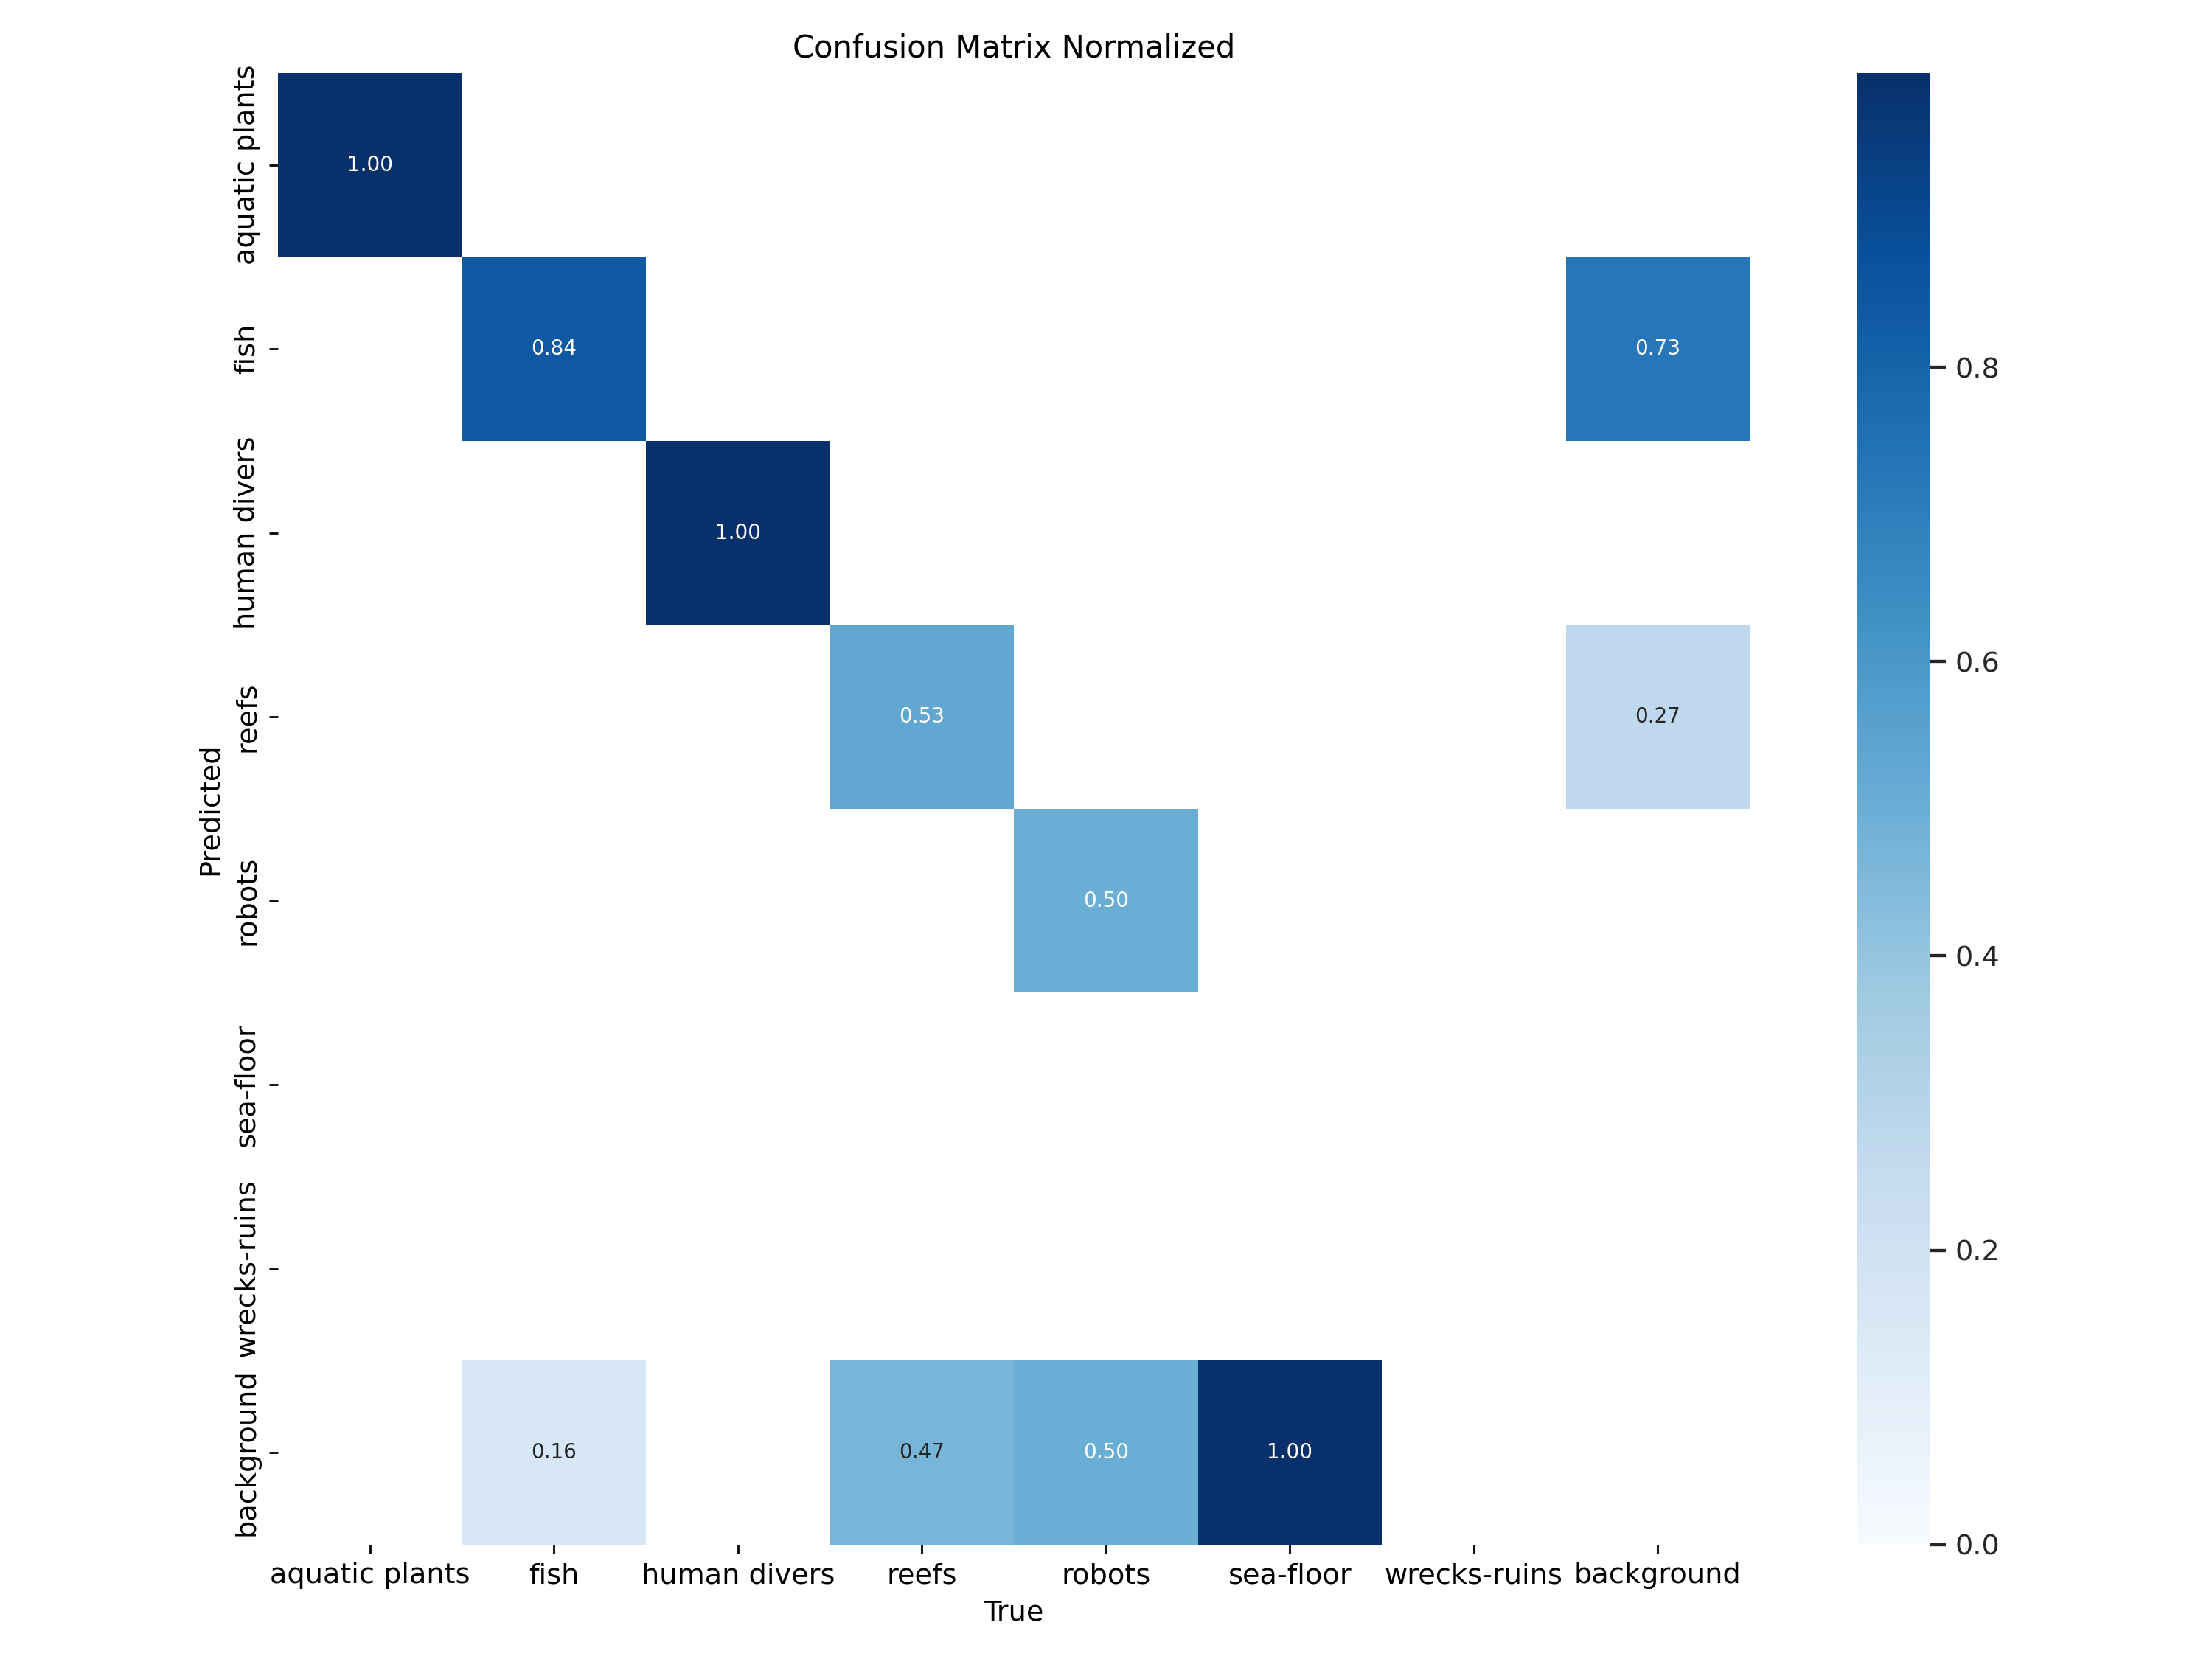

In [10]:



from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/Underwater-Instance-Segmentation-3/runs/segment/train/confusion_matrix_normalized.png', width=600)

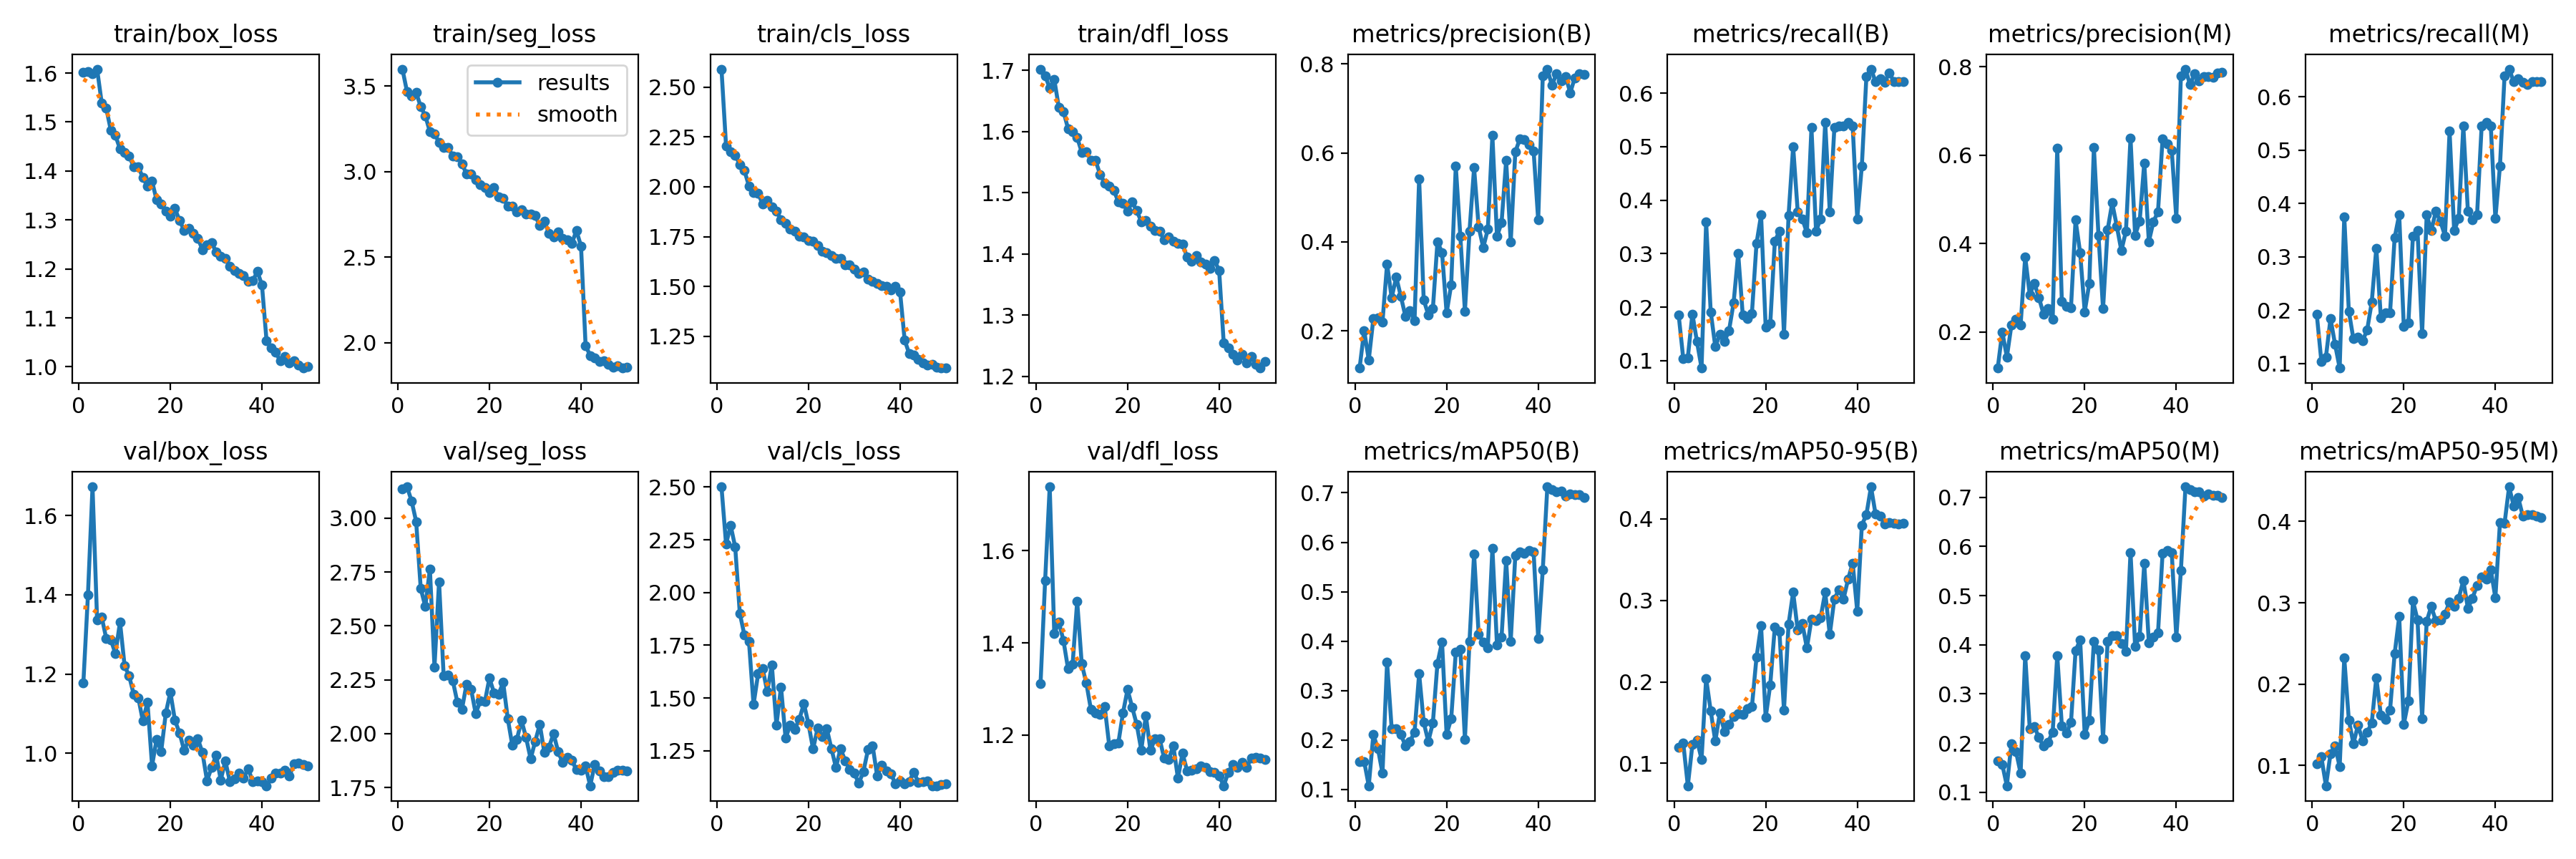

In [11]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/Underwater-Instance-Segmentation-3/runs/segment/train/results.png', width=600)

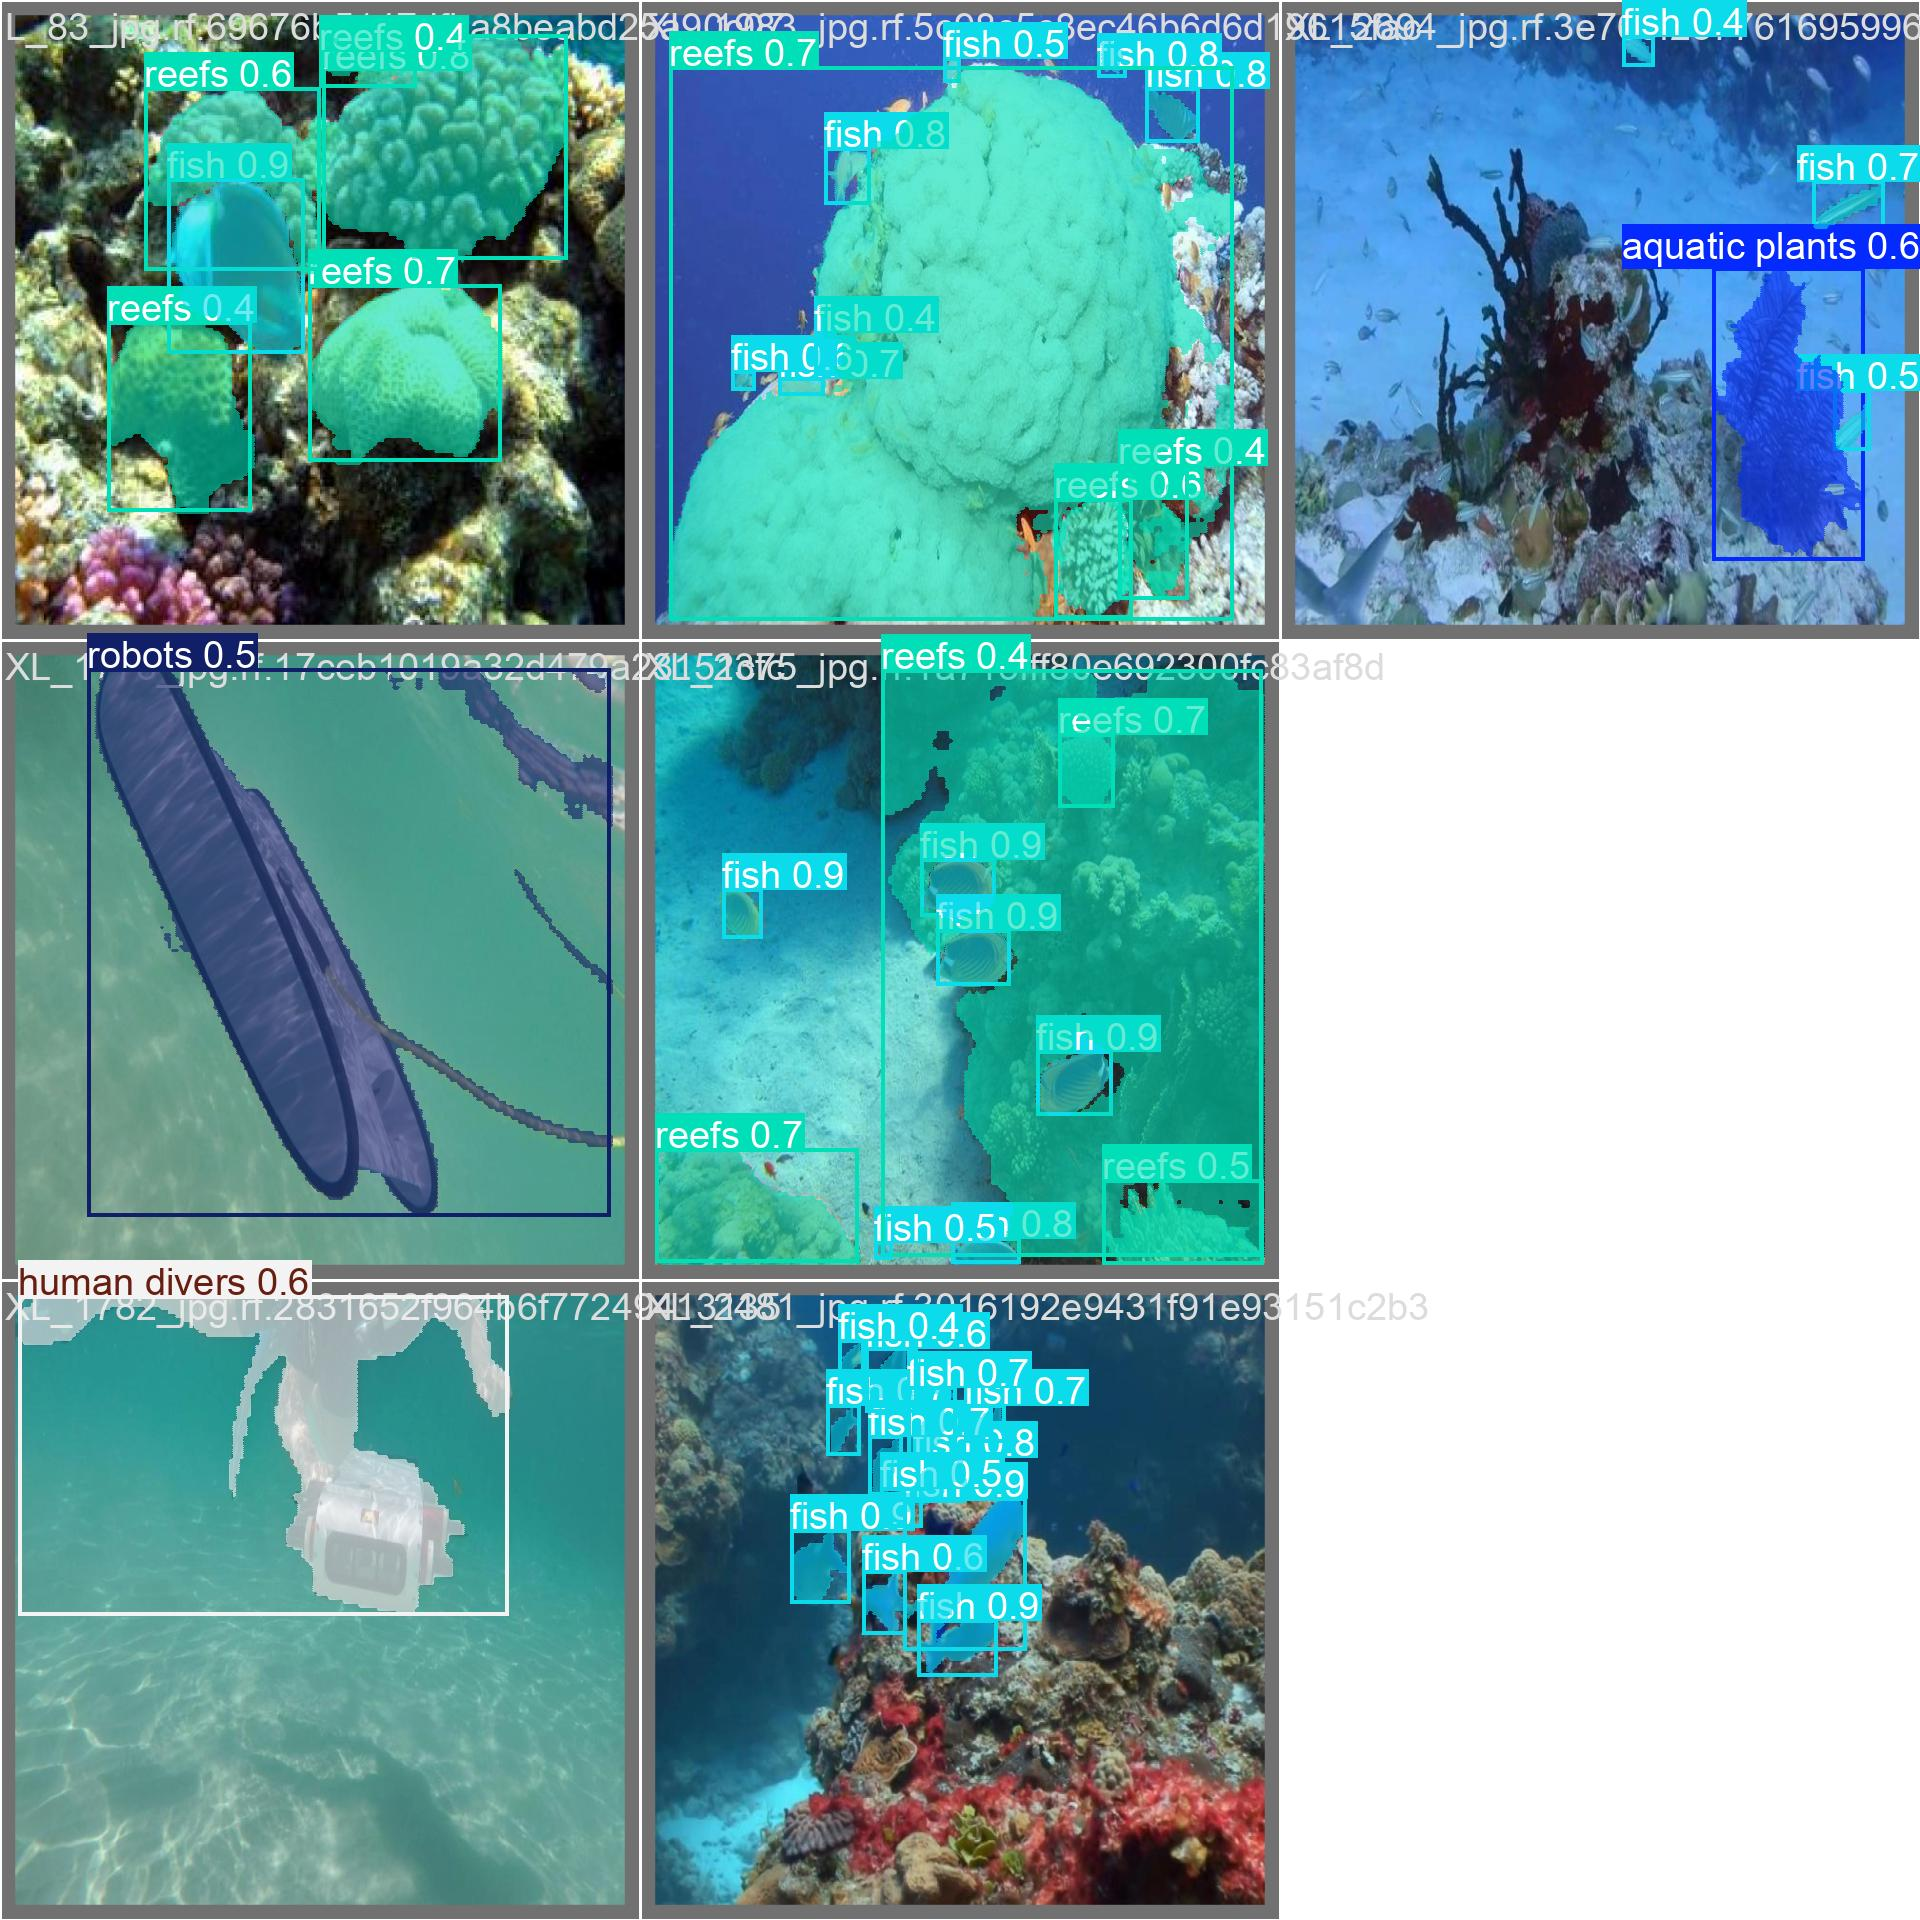

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/Underwater-Instance-Segmentation-3/runs/segment/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [13]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!yolo val model=/content/Underwater-Instance-Segmentation-3/best.pt data=/content/Underwater-Instance-Segmentation-3/data.yaml task=segment

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,069,525 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /content/Underwater-Instance-Segmentation-3/valid/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100% 7/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  1.98it/s]
                   all          7         47       0.87      0.616      0.787      0.437      0.877      0.623      0.709       0.43
        aquatic plants          1          1      0.896          1      0.995      0.416      0.896          1      0.995      0.697
                  fish          4         25      0.722      0.726      0.798      0.602      0.761      0.766      0.839      0.572
          human divers          1          1      0.762          1      0.995      0.323      0.762          1      0.99

## Inference with custom model

In [14]:
!yolo task=segment mode=predict model=/content/Underwater-Instance-Segmentation-3/best.pt conf=0.25 source=/content/Underwater-Instance-Segmentation-3/train/images

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,069,525 parameters, 0 gradients, 35.3 GFLOPs

image 1/2748 /content/Underwater-Instance-Segmentation-3/train/images/L_1002_jpg.rf.9b64cf3ecd5d372bb3dbdc146759e077.jpg: 640x640 1 fish, 3 sea-floors, 20.2ms
image 2/2748 /content/Underwater-Instance-Segmentation-3/train/images/L_1003_jpg.rf.09e1114fbc65a46732bfd5db9d1c3ba0.jpg: 640x640 1 reefs, 20.3ms
image 3/2748 /content/Underwater-Instance-Segmentation-3/train/images/L_1004_jpg.rf.b25c9dd858f25f215881413435bdfd89.jpg: 640x640 1 reefs, 20.2ms
image 4/2748 /content/Underwater-Instance-Segmentation-3/train/images/L_1005_jpg.rf.cb333bc60fb0002a759bac8dc770995e.jpg: 640x640 3 fishs, 4 reefss, 20.1ms
image 5/2748 /content/Underwater-Instance-Segmentation-3/train/images/L_1007_jpg.rf.ebe3d4cf21daa83397be1f14835a9e8c.jpg: 640x640 4 fishs, 4 reefss, 20.2ms
image 6/2748 /content/Underwater-Instance-Segmentation-3/train/im

**NOTE:** Let's take a look at few results.

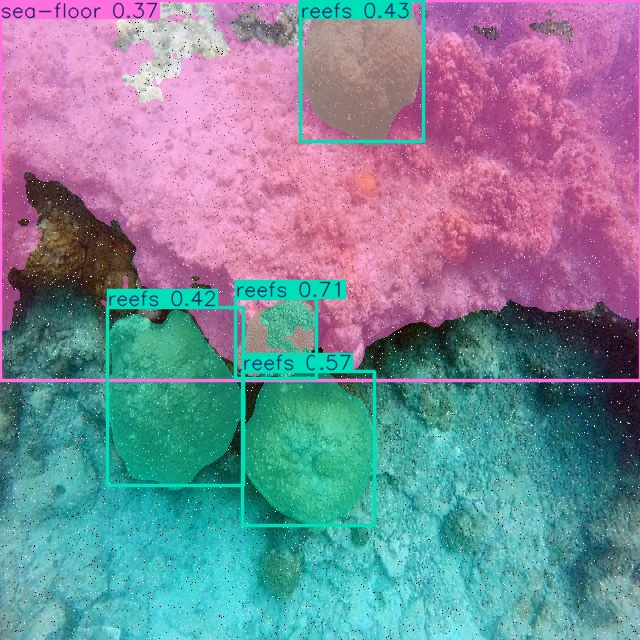

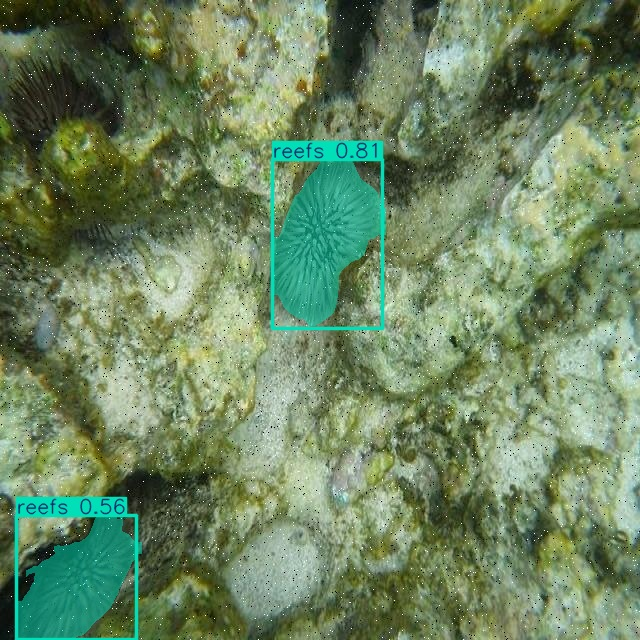

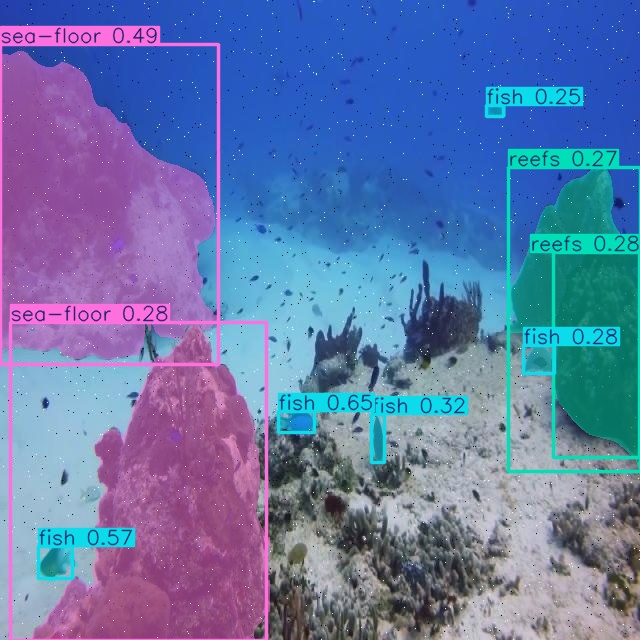

In [15]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [16]:
model.val()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,069,525 parameters, 0 gradients, 35.3 GFLOPs


val: Scanning /content/Underwater-Instance-Segmentation-3/valid/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


                   all          7         47      0.751      0.645      0.707      0.439      0.758      0.652      0.716      0.442
        aquatic plants          1          1          1          1      0.995      0.398          1          1      0.995      0.697
                  fish          4         25      0.738       0.84      0.807      0.652      0.776       0.88       0.86      0.613
          human divers          1          1          1          1      0.995      0.298          1          1      0.995      0.199
                 reefs          4         17      0.769      0.529      0.696      0.611      0.773      0.529      0.696      0.543
                robots          2          2          1        0.5       0.75      0.675          1        0.5       0.75        0.6
             sea-floor          1          1          0          0          0          0          0          0          0          0
Speed: 0.4ms preprocess, 29.6ms inference, 0.0ms loss, 0.9ms postproc

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f712ab0bdd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004

In [17]:
import shutil

folder_to_download = '/content/Underwater-Instance-Segmentation-3'
output_filename = '/content/Underwater-Instance-Segmentation-3_backup'

shutil.make_archive(output_filename, 'zip', folder_to_download)


'/content/Underwater-Instance-Segmentation-3_backup.zip'

In [18]:
from google.colab import files

files.download(output_filename + '.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>